### Importation / Configuration

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from utils.confusion_matrix import confusion_matrix

In [2]:
starbucks = pd.read_csv("clean_starbucks.csv")

In [3]:
z = starbucks.Category

starbucks.drop(columns=["Category", "size", "product_name"], axis=1, inplace=True)


### Entrainement et prédiction

In [4]:
X_train, X_test, z_train, z_test = train_test_split(starbucks, z, test_size=0.33, random_state=40)

cls = LogisticRegression(solver="newton-cg")
#search = GridSearchCV(cls, scoring="accuracy", cv=10)

cls.fit(X_train, z_train)

z_pred = cls.predict(X_test)

accuracy_score(z_pred, z_test)



0.9129287598944591

### Matrice de confusion

In [5]:
confusion_df = confusion_matrix(z_test, z_pred)
confusion_df

Prédiction,chocolate,coffee,frappuccino,other,tea
Réalité,,,,,
chocolate,100.000000,0.000000,0.000000,0.000000,0.000000
coffee,0.000000,90.566038,6.289308,0.000000,3.144654
frappuccino,0.000000,7.476636,91.588785,0.000000,0.934579
other,15.384615,0.000000,0.000000,61.538462,23.076923
tea,0.000000,5.405405,0.000000,0.000000,94.594595


<Axes: xlabel='Prédiction', ylabel='Réalité'>

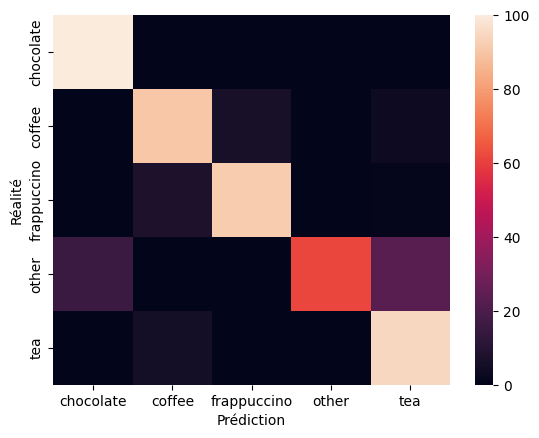

In [6]:
sns.heatmap(confusion_df)

### Significativité des coefficients

#### Importance moyenne dans toutes les classes

<Axes: ylabel='Feature'>

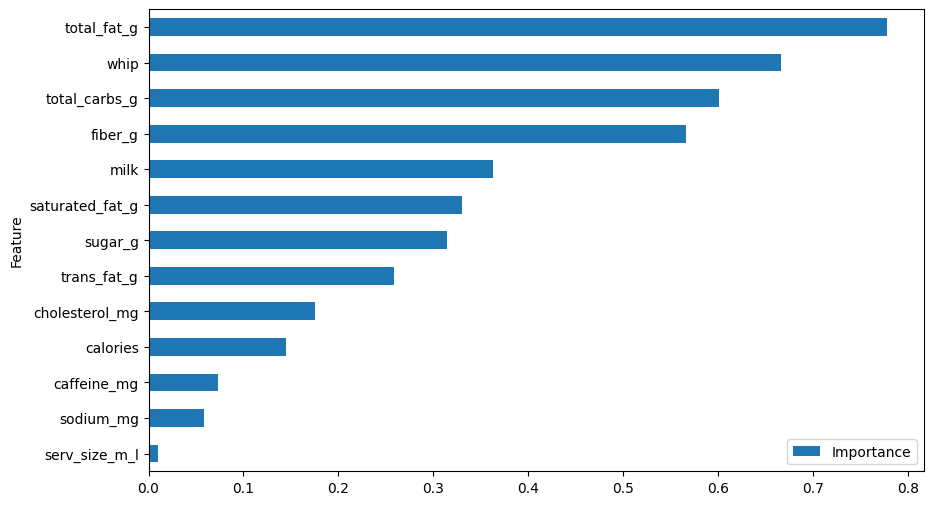

In [8]:
coefficients = cls.coef_

avg_importance = np.mean(np.abs(coefficients), axis=0)
feature_importance = pd.DataFrame({'Feature': starbucks.columns, 'Importance': avg_importance})
feature_importance = feature_importance.sort_values('Importance', ascending=True)
feature_importance.plot(x='Feature', y='Importance', kind='barh', figsize=(10, 6))

In [36]:
def feature_importance(cls, class_label):
    class_index = np.where(cls.classes_ == class_label)[0][0]

    feature_importance = pd.DataFrame({'Feature': starbucks.columns, 'Importance': cls.coef_[class_index]})
    feature_importance = feature_importance.sort_values('Importance', ascending=True)
    feature_importance.plot(x='Feature', y='Importance', kind='barh', figsize=(10, 6))

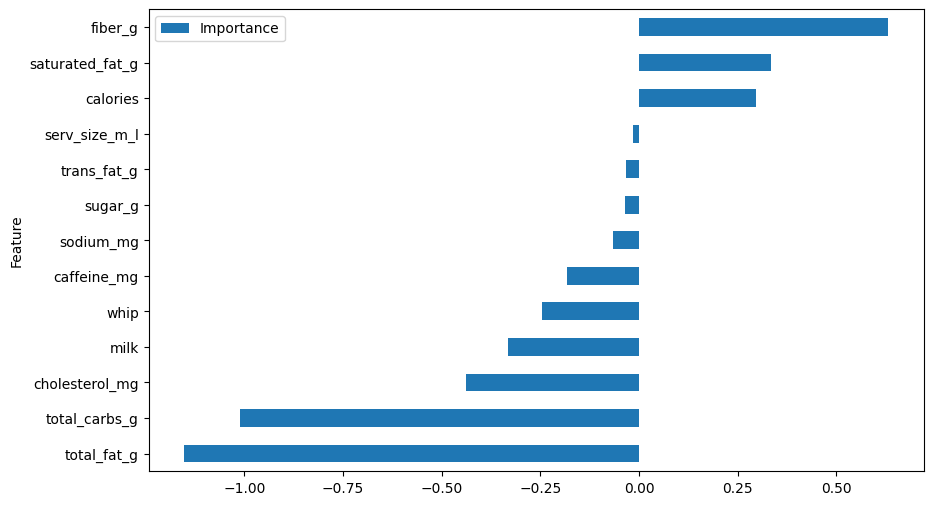

In [37]:
feature_importance(cls, "chocolate")

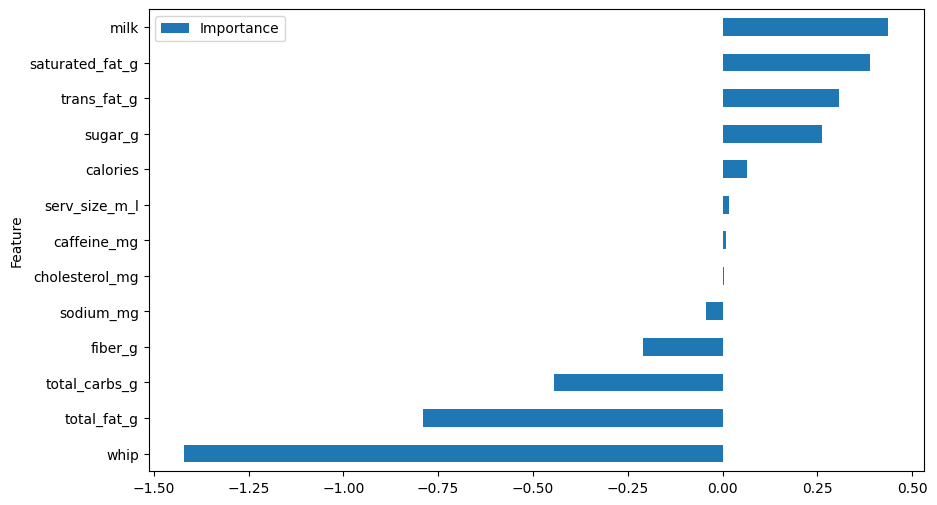

In [38]:
feature_importance(cls, "tea")

1
[ 0.10975608  0.65589371  0.00177563 -0.03075456  0.11591103  0.07400574
 -0.61496324  0.08086031  0.01312203 -0.04436324 -0.27666136  0.05913747
  0.11112065]


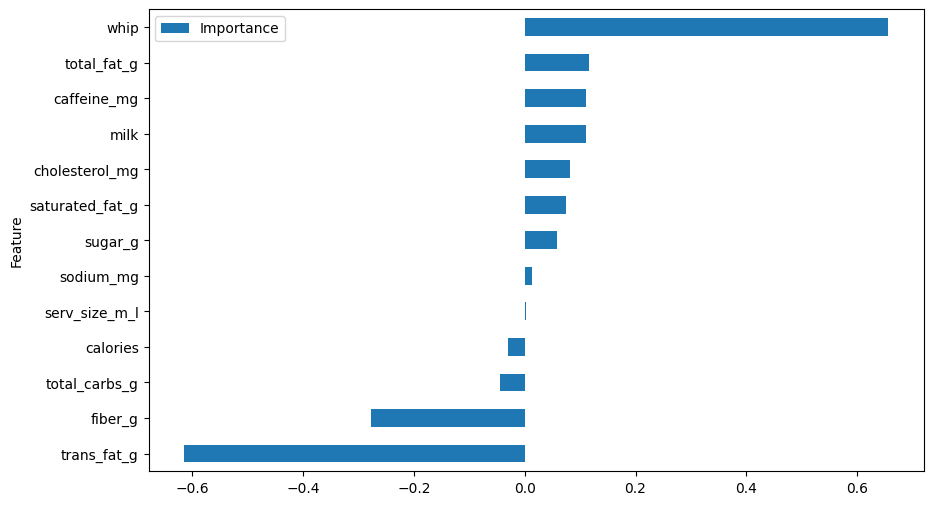

In [35]:
feature_importance(cls, "coffee")

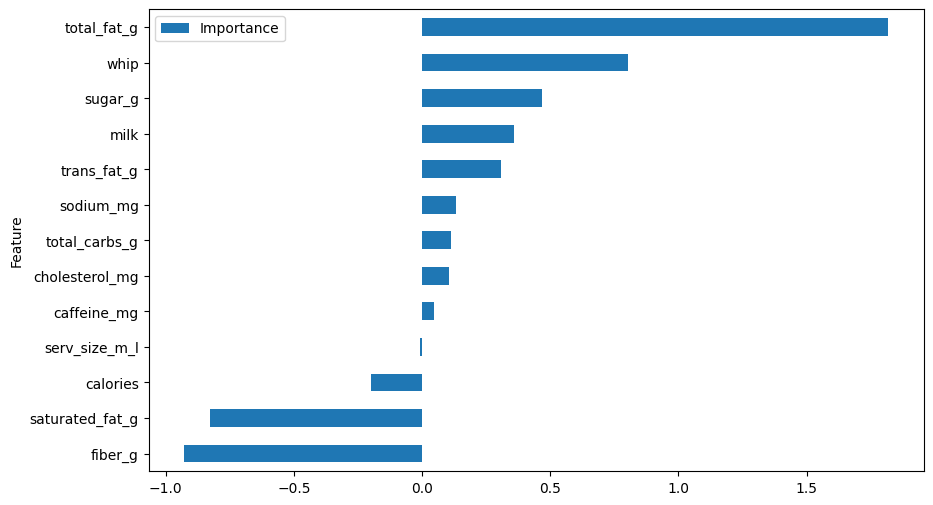

In [40]:
feature_importance(cls, "frappuccino")

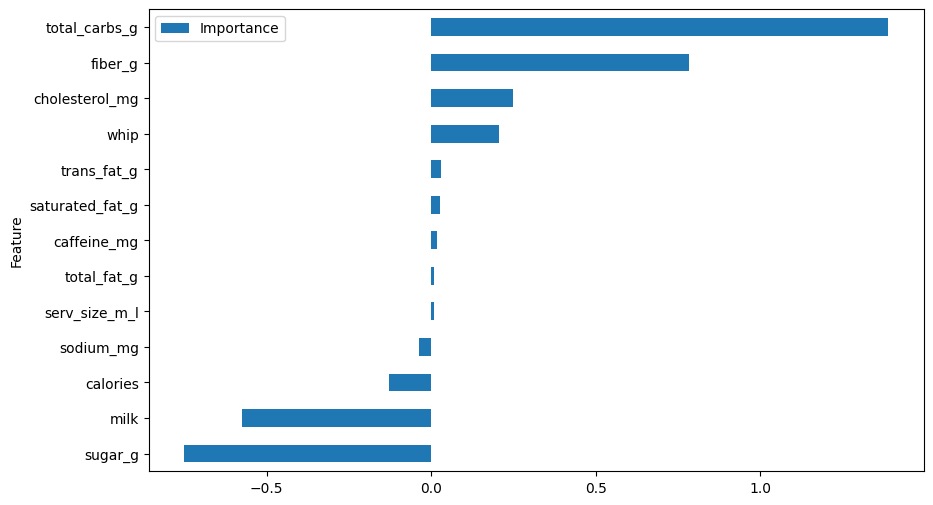

In [41]:
feature_importance(cls, "other")